# Best Model evaluation

In [1]:
import glob
import os
import sys
import time
import re

os.environ["LOKY_PICKLER"] = 'cloudpickle'
import multiprocessing

#multiprocessing.set_start_method('forkserver')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

from fbprophet import Prophet
from joblib import Parallel, delayed
from pyramid.arima import auto_arima, ARIMA
from sklearn import neighbors, ensemble, tree, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
def create_artificial_features(series, frequency='H', steps=7, weekdays=False, months=False, statistical=True):
    """
    Creates artificial features for a given series with Timestamp Index

    :param series:      the base series to use
    :param frequency:   the frequency of values in the series
    :param steps:       the amount of steps to lag the series by
    :return:            the dataframe containing the artificial features for the input series
    """
    #interpolated = series.interpolate(method='time', frequency=frequency)
    lagged = create_lagged_features(series, frequency, steps)
    statistics = lagged

    if statistical:
        statistics['sum'] = lagged.sum(axis=1)
        statistics['mean'] = lagged.mean(axis=1)
        statistics['median'] = lagged.median(axis=1)

    if weekdays:
        weekdays_df = pd.get_dummies(lagged.index.weekday_name)
        weekdays_df = weekdays_df.applymap(lambda x: bool(x))
        weekdays_df.index = lagged.index
        statistics = statistics.join(weekdays_df)

    if months:
        months_df = pd.get_dummies(lagged.index.month.map(lambda x: calendar.month_abbr[x]))
        months_df = months_df.applymap(lambda x: bool(x))
        months_df.index = lagged.index
        statistics = statistics.join(months_df)

    return statistics


def create_lagged_features(series, frequency='H', steps=7):
    """
    Creates a dataframe from a series containing the original series and the lagged values for the specified amount of
    steps.

    :param series:      the series to use
    :param frequency:   the frequency of the values by which to shift
    :param steps:       the amount of steps to shift
    :return:            the shifted dataframe
    """
    lagged = pd.DataFrame()

    for i in range(1, steps + 1):
        lagged['lag {}{}'.format(i, frequency)] = series.shift(i, freq=frequency)

    lagged.index = series.index

    return lagged.interpolate()

def resample_dataframe(dataframe, rate='H'):
    """
    Resamples a dataframe according to a given rate.

    :param dataframe:   The dataframe to resample
    :param rate:        The rate to use ('D' or 'H')
    :return:            The resampled dataframe
    """
    if rate == 'D':
        dataframe = dataframe.resample(rate).bfill(limit=1).interpolate(
            method='time')  # bfill is used here, because daily values act up otherwise
    else:
        dataframe = dataframe.resample(rate).interpolate(method='time')
    return dataframe.dropna()


def get_info(csv_path, directory):
    """
    Gets station name and rate from a csv path string

    :param csv_path:    The path string
    :param directory:   The directory of the csv
    :return:            The station name and rate
    """
    info = csv_path.replace(f'{directory}/', '').replace('.csv', '').split('-')
    station_name = info[0]
    rate = {'day': 'D', 'hour': 'H'}[info[-1]]
    return station_name, rate


def create_gru(weights, input_shape, dropout_rate, learning_rate):
    """
    Creates a GRU based RNN using the given input parameters.

    :param weights:         The amount of output weights for GRU layer
    :param input_shape:     The shape of the inputs
    :param dropout_rate:    The dropout rate after GRU layer
    :param learning_rate:   The learning rate of the optimizer
    :return:                The compiled model
    """
    from tensorflow.python.keras import Sequential, optimizers
    from tensorflow.python.keras.layers import GRU, Dropout, Dense

    optimizer = optimizers.RMSprop(lr=learning_rate)

    model = Sequential()
    model.add(GRU(weights, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer, loss='mse')
    return model


def scale_array(array, feature_range=(-1, 1)):
    x = array
    x = x.reshape(len(x), 1)
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler = scaler.fit(x)
    scaled = scaler.transform(x)
    scaled = scaled.reshape(len(scaled))
    return scaled, scaler


def scale_series(series, feature_range=(-1, 1)):
    """
    Downscales a series to given feature_range.

    :param series:          The series to downscale
    :param feature_range:   The range of values after scaling
    :return:                The scaled series and used scaler
    """
    x = series.values
    scaled, scaler = scale_array(x, feature_range)
    scaled_series = pd.Series(data=scaled, index=series.index)
    return scaled_series, scaler


def scale_dataframe(dataframe, feature_range=(-1, 1)):
    """
    Downscales all values in a dataframe to given feature_range.

    :param dataframe:       The dataframe to downscale
    :param feature_range:   The range of values after scaling
    :return:                The scaled dataframe and used scaler
    """
    x = dataframe.values
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler = scaler.fit(x)
    scaled = scaler.transform(x)
    scaled_dataframe = pd.DataFrame(scaled, columns=dataframe.columns, index=dataframe.index)
    return scaled_dataframe, scaler


def rescale_array(array, scaler):
    x = array
    x = x.reshape(len(x), 1)
    rescaled = scaler.inverse_transform(x)
    rescaled = rescaled.reshape(len(rescaled))
    return rescaled


def rescale_series(series, scaler):
    """
    Rescales a series using given scaler.

    :param series:  The series to rescale
    :param scaler:  The scaler used to scale the series
    :return:        The rescaled series
    """
    x = series.values
    rescaled = rescale_array(x, scaler)
    rescaled_series = pd.Series(data=rescaled, index=series.index)
    return rescaled_series


def rescale_dataframe(dataframe, scaler):
    """
    Rescales a dataframe using given scaler.

    :param dataframe:   The dataframe to rescale
    :param scaler:      The scaler used for scaling of dataframe
    :return:            The rescaled dataframe
    """
    x = dataframe.values
    rescaled = scaler.inverse_transform(x)
    rescaled_dataframe = pd.DataFrame(rescaled, columns=dataframe.columns, index=dataframe.index)
    return rescaled_dataframe


def scale_inputs(x, y):
    """
    Downscales a dataframe x and a series y

    :param x:   The dataframe to downscale
    :param y:   The series to downscale
    :return:    The downscaled dataframe, series and their used scalers for rescaling later on
    """
    scaled_x, x_scaler = scale_dataframe(x)
    scaled_y, y_scaler = scale_series(y)
    return scaled_x, scaled_y, x_scaler, y_scaler


def rescale_input(x, y, x_scaler, y_scaler):
    """
    Rescales a scaled dataframe x and series y using their specified scalers used for downscaling.

    :param x:           The dataframe to rescale
    :param y:           The series to rescale
    :param x_scaler:    The scaler used for the dataframe
    :param y_scaler:    The scaler used for the series
    :return:            The rescaled dataframe and series
    """
    rescaled_x = rescale_dataframe(x, x_scaler)
    rescaled_y = rescale_series(y, y_scaler)
    return rescaled_x, rescaled_y


def rotate_series(series):
    """
    Rotates a series to the left by one.
    The original first item becomes the last.

    :param series:  The series to rotate
    :return:        The rotated series
    """
    return pd.concat([series[1:], pd.Series(series.iloc[0])])

def difference_series(series, stepsize=1):
    """
    Differentiates a Pandas Series object.
    The returned Series does not contain the first index of the input, because there is now sensible value for it.

    :param series:      The series to differentiate
    :param stepsize:    The stepsize to use for differentiation
    :return:            The differentiated Series
    """
    return series.diff(periods=stepsize).iloc[stepsize:]


def dedifference_series(series, start_level, stepsize=1):
    """
    Inverse transforms a differentiated Pandas Series Object.
    The start_level needs to be the original series' first index to get the original series.
    The inversion works via summation from the start_level.

    :param series:      The differentiated series
    :param start_level: The start level to use for the inversion.
    :param stepsize:    The stepsize used for differentiation
    :return:            The dedifferentiated series
    """
    dediff = list()
    summed = start_level
    for i in range(0, len(series), stepsize):
        summed += series.iloc[i]
        dediff.append(summed)
    out = pd.Series(dediff)
    out.index = series.index
    return out


def difference_dataframe(dataframe, stepsize=1):
    """
    Differentiates all columns in a dataframe.

    :param dataframe:   The dataframe to differentiate
    :param stepsize:    The stepsize to use for differentiation
    :return:            The differentiated dataframe
    """
    return dataframe.diff(periods=stepsize).iloc[stepsize:]


def dediffference_dataframe(dataframe, start_row, stepsize=1):
    """
    Inverses the differentiation of a dataframe using a given start_row.

    :param dataframe:   The dataframe to dedifferentiate
    :param start_row:   The starting row values to inverse differentiation from
    :param stepsize:    The stepsize used for differentiation
    :return:            The dedifferentiated dataframe
    """
    dediff = pd.DataFrame()
    sums = start_row
    for i in range(0, len(dataframe), stepsize):
        sums = sums.add(dataframe.iloc[i])
        dediff = dediff.append(pd.DataFrame([sums]))
    dediff.index = dataframe.index
    return dediff


def build_save_string(station, pollutant, distance, differenced, direct, artificial):
    """
    Builds the save location string for the given inputs.
    The filetype will be a csv file.

    :param station:     The station for which the data is saved
    :param pollutant:   The pollutant
    :param distance:    The forecast distance
    :param differenced: If the dataframe was differenced
    :param direct:      If the forecast uses a direct model
    :param artificial:  If the forecast used the artificial set or other pollutants
    :return:            The save location string
    """
    savepath = f'./results/{station}-{pollutant}-distance={distance}-differenced={differenced}-direct={direct}'
    if direct:
        savepath += f'-artificial={artificial}'
    savepath += '.csv'
    return savepath

def deconstruct_save_string(savestring, folder):
    split = savestring.replace('.csv', '').replace(f'{folder}/', '').split('-')
    return {'station': split[0],
           'pollutant': split[1],
           'distance': split[2].replace('distance=', ''),
           'differenced': split[3].replace('differenced=', ''),
           'direct': split[4].replace('direct=', ''),
           'artificial': split[5].replace('artificial=', '') if len(split) == 6 else 'False'}

def get_arima_params(df, selector):
    params = ['callback', 'disp', 'maxiter', 'method', 'order', 'out_of_sample_size', 'scoring', 'scoring_args', 'seasonal_order', 'solver', 'start_params', 'suppress_warnings', 'transparams', 'trend']
    params_dict = dict()
    for k in params:
        if k == 'order' or k == 'seasonal_order' or k == 'scoring_args':
            value = eval(df[(df.model == 'arima') & selector][k].iloc[0])
        else:
            value = df[(df.model == 'arima') & selector][k].iloc[0]

        if not (type(value) is np.float64 and np.isnan(value)):
            if type(value) is np.float64:
                value = int(value)
            params_dict[k] = value
    return params_dict

def get_ets_params(df, selector):
    params = ['smoothing_level', 'smoothing_slope', 'smoothing_seasonal', 'damping_slope', 'initial_level', 'initial_slope', 'initial_seasons', 'use_boxcox', 'lamda', 'remove_bias']
    params_dict = dict()
    for k in params:
        if k == 'initial_seasons':
            value = eval(re.sub(' +(\n)*', ', ', df[(df.model == 'ets') & selector][k].iloc[0]))
        else:
            value = df[(df.model == 'ets') & selector][k].iloc[0]
        params_dict[k] = value
    return params_dict

def get_knn_params(df, selector):
    params = ['n_neighbors', 'weights']
    params_dict = dict()
    for k in params:
        value = df[(df.model == 'knn') & selector][k].iloc[0]
        if type(value) is np.float64:
            value = int(value)
        params_dict[k] = value
    return params_dict

def get_decision_tree_params(df, selector):
    params = ['max_depth']
    params_dict = dict()
    for k in params:
        value = df[(df.model == 'decision_tree') & selector][k].iloc[0]
        if type(value) is np.float64:
            value = int(value)
        params_dict[k] = value
    return params_dict

def get_random_forest_params(df, selector):
    params = ['n_estimators', 'max_depth']
    params_dict = dict()
    for k in params:
        value = df[(df.model == 'random_forest') & selector][k].iloc[0]
        if type(value) is np.float64:
            value = int(value)
        params_dict[k] = value
    return params_dict

def get_linear_regression_params(df, selector):
    params = ['normalize']
    params_dict = dict()
    for k in params:
        value = df[(df.model == 'linear_regression') & selector][k].iloc[0]
        params_dict[k] = value
    return params_dict

def get_gru_params(df, selector):
    params = ['weights', 'dropout_rate', 'input_shape', 'epochs', 'batch_size', 'learning_rate']
    params_dict = dict()
    for k in params:
        value = df[(df.model == 'gru') & selector][k].iloc[0]
        if k == 'weights' or k == 'epochs' or k == 'batch_size':
            value = int(value)
        elif k == 'input_shape':
            value = eval(value)
        params_dict[k] = value
    return params_dict

In [3]:
csv = './post/DEHH033-hour.csv'
station_name, steprate = get_info(csv, './post')
df = pd.read_csv(csv, index_col=0, parse_dates=[0], infer_datetime_format=True) \
    .drop(columns=['AirQualityStationEoICode', 'AveragingTime'])
df = resample_dataframe(df, steprate)
diff = difference_dataframe(df)
statsdf = pd.DataFrame()
artificial = create_artificial_features(df['O3'][:8760], steps=24)[24:]
direct_y = df.drop(columns=['O3'])[:8760]

for item in glob.glob(f'./results/{station_name}*.csv'):
    info = deconstruct_save_string(item, './results')
    currentdf = pd.read_csv(item, index_col=0)
    
    for key, value in info.items():
        currentdf[key] = value
    
    statsdf = pd.concat([statsdf, currentdf])
    
statsdf = statsdf.reset_index().drop(columns=['level_0'])

In [4]:
arima_params = get_arima_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False'))
arima = ARIMA(**arima_params)
arima_fit = arima.fit(y = df['O3'][:8760])
arima_pred = arima_fit.predict(24)

In [19]:
ets_params = get_ets_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False'))
ets = ExponentialSmoothing(df['O3'][:8760][:-24])
ets.params = ets_params
ets_fit = ets.fit()
ets_pred = ets_fit.predict(start=8760-23, end=8760)

In [7]:
prophet = Prophet().fit(pd.DataFrame(data={
    'ds': df.index[:8760][:-24],
    'y': df['O3'][:8760][:-24]
}))
prophet_pred = prophet.predict(prophet.make_future_dataframe(24, 'H'))['yhat'][-24:]

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
a_knn_params = get_knn_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'True') &(statsdf['distance'] == '1'))
a_knn_model = neighbors.KNeighborsRegressor(**a_knn_params)
a_knn_fit = a_knn_model.fit(artificial[:-24], df['O3'][24:8760][:-24])
a_knn_pred = a_knn_fit.predict(artificial[-24:])

d_knn_params = get_knn_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'True') &(statsdf['distance'] == '1'))
d_knn_model = neighbors.KNeighborsRegressor(**d_knn_params)
d_knn_fit = d_knn_model.fit(direct_y[:-24], df['O3'][:8760][:-24])
d_knn_pred = d_knn_fit.predict(direct_y[-24:])

/usr/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:285: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/usr/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:285: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [9]:
a_dtree_params = get_decision_tree_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'True') &(statsdf['distance'] == '1'))
a_dtree_model = tree.DecisionTreeRegressor(**a_dtree_params)
a_dtree_fit = a_dtree_model.fit(artificial[:-24], df['O3'][24:8760][:-24])
a_dtree_pred = a_dtree_fit.predict(artificial[-24:])

d_dtree_params = get_decision_tree_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'False') &(statsdf['distance'] == '1'))
d_dtree_model = tree.DecisionTreeRegressor(**d_dtree_params)
d_dtree_fit = d_dtree_model.fit(direct_y[:-24], df['O3'][:8760][:-24])
d_dtree_pred = d_dtree_fit.predict(direct_y[-24:])

In [10]:
a_rforest_params = get_random_forest_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'True') &(statsdf['distance'] == '1'))
a_rforest_model = ensemble.RandomForestRegressor(**a_rforest_params)
a_rforest_fit = a_dtree_model.fit(artificial[:-24], df['O3'][24:8760][:-24])
a_rforest_pred = a_dtree_fit.predict(artificial[-24:])

d_rforest_params = get_random_forest_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'False') &(statsdf['distance'] == '1'))
d_rforest_model = ensemble.RandomForestRegressor(**d_rforest_params)
d_rforest_fit = d_dtree_model.fit(direct_y[:-24], df['O3'][:8760][:-24])
d_rforest_pred = d_dtree_fit.predict(direct_y[-24:])

In [11]:
a_regression_params = get_linear_regression_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'True') &(statsdf['distance'] == '1'))
a_regression_model = linear_model.LinearRegression(**a_regression_params)
a_regression_fit = a_dtree_model.fit(artificial[:-24], df['O3'][24:8760][:-24])
a_regression_pred = a_dtree_fit.predict(artificial[-24:])

d_regression_params = get_linear_regression_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'False') &(statsdf['distance'] == '1'))
d_regression_model = linear_model.LinearRegression(**d_regression_params)
d_regression_fit = d_dtree_model.fit(direct_y[:-24], df['O3'][:8760][:-24])
d_regression_pred = d_dtree_fit.predict(direct_y[-24:])

In [12]:
a_x, a_y, a_x_scaler, a_y_scaler = scale_inputs(artificial, df['O3'][24:8760])
a_x = a_x.values.reshape(a_x.shape[0], a_x.shape[1], 1)
a_y = a_y.values

d_x, d_y, d_x_scaler, d_y_scaler = scale_inputs(direct_y, df['O3'][:8760])
d_x = d_x.values.reshape(d_x.shape[0], d_x.shape[1], 1)
d_y = d_y.values

from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.backend import clear_session

a_gru_params = get_gru_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'True') &(statsdf['distance'] == '1'))
a_gru_model = KerasRegressor(build_fn=create_gru, **a_gru_params)
a_gru_fit = a_gru_model.fit(a_x[:-24], a_y[:-24])
a_gru_pred = rescale_array(a_gru_model.predict(a_x[-24:]), a_y_scaler)

d_gru_params = get_gru_params(statsdf, (statsdf['pollutant'] == 'O3') & (statsdf['differenced'] == 'False') & (statsdf['artificial'] == 'False') &(statsdf['distance'] == '1'))
d_gru_model = KerasRegressor(build_fn=create_gru, **d_gru_params)
d_gru_fit = d_gru_model.fit(d_x[:-24], d_y[:-24])
d_gru_pred = rescale_array(d_gru_model.predict(d_x[-24:]), d_y_scaler)

Epoch 1/9
8712/8712 [==============================] - 7s 830us/step - loss: 0.0627
Epoch 2/9
8712/8712 [==============================] - 7s 770us/step - loss: 0.0314
Epoch 3/9
8712/8712 [==============================] - 7s 822us/step - loss: 0.0193
Epoch 4/9
8712/8712 [==============================] - 7s 777us/step - loss: 0.0126
Epoch 5/9
8712/8712 [==============================] - 7s 783us/step - loss: 0.0094
Epoch 6/9
8712/8712 [==============================] - 7s 787us/step - loss: 0.0071
Epoch 7/9
8712/8712 [==============================] - 7s 786us/step - loss: 0.0062
Epoch 8/9
8712/8712 [==============================] - 7s 784us/step - loss: 0.0052
Epoch 9/9
8712/8712 [==============================] - 7s 803us/step - loss: 0.0047
Epoch 1/3
8736/8736 [==============================] - 11s 1ms/step - loss: 0.0971
Epoch 2/3
8736/8736 [==============================] - 11s 1ms/step - loss: 0.0750
Epoch 3/3
8736/8736 [==============================] - 11s 1ms/step - loss: 0.

In [23]:
pre = df['O3'][8760-int(1.5*24):8760][:-24]
actual = df['O3'][8760-int(1.5*24):8760][-24:]

<IPython.core.display.Javascript object>


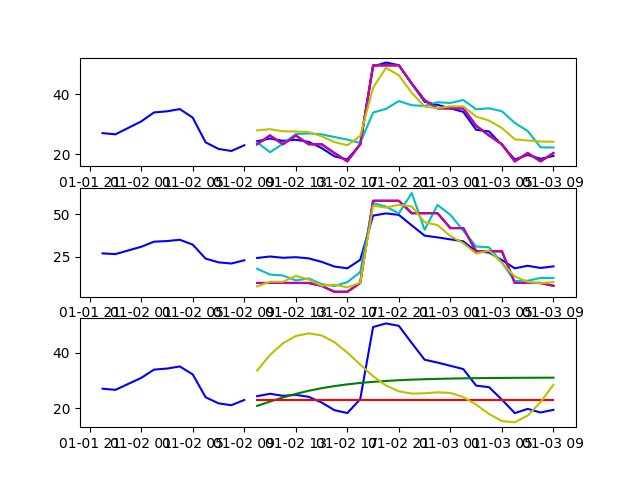

In [37]:
%matplotlib notebook
plt.figure(1)
plt.subplot(311)
plt.plot(pre.index, pre, 'b')
plt.plot(actual.index, actual, 'b')
plt.plot(actual.index, a_dtree_pred, 'g')
plt.plot(actual.index, a_rforest_pred, 'r')
plt.plot(actual.index, a_knn_pred, 'c')
plt.plot(actual.index, a_regression_pred, 'm')
plt.plot(actual.index, a_gru_pred, 'y')

plt.subplot(312)
plt.plot(pre.index, pre, 'b')
plt.plot(actual.index, actual, 'b')
plt.plot(actual.index, d_dtree_pred, 'g')
plt.plot(actual.index, d_rforest_pred, 'r')
plt.plot(actual.index, d_knn_pred, 'c')
plt.plot(actual.index, d_regression_pred, 'm')
plt.plot(actual.index, d_gru_pred, 'y')

plt.subplot(313)
plt.plot(pre.index, pre, 'b')
plt.plot(actual.index, actual, 'b')
plt.plot(actual.index, arima_pred, 'g')
plt.plot(actual.index, ets_pred, 'r')
plt.plot(actual.index, prophet_pred, 'y')

In [33]:
ets_fit.predict(8736, 8760)

2014-01-02 10:00:00    22.932
2014-01-02 11:00:00    22.932
2014-01-02 12:00:00    22.932
2014-01-02 13:00:00    22.932
2014-01-02 14:00:00    22.932
2014-01-02 15:00:00    22.932
2014-01-02 16:00:00    22.932
2014-01-02 17:00:00    22.932
2014-01-02 18:00:00    22.932
2014-01-02 19:00:00    22.932
2014-01-02 20:00:00    22.932
2014-01-02 21:00:00    22.932
2014-01-02 22:00:00    22.932
2014-01-02 23:00:00    22.932
2014-01-03 00:00:00    22.932
2014-01-03 01:00:00    22.932
2014-01-03 02:00:00    22.932
2014-01-03 03:00:00    22.932
2014-01-03 04:00:00    22.932
2014-01-03 05:00:00    22.932
2014-01-03 06:00:00    22.932
2014-01-03 07:00:00    22.932
2014-01-03 08:00:00    22.932
2014-01-03 09:00:00    22.932
2014-01-03 10:00:00    22.932
Freq: H, dtype: float64